# Predicting the Past, United States Extension

## Introduction
This is an extension of Predicting the Past, United States. 
The extension includes comparisons between Cyclus output and CURIE data at year 2020 for: 
 - Total spent fuel mass 
 - Mass of major isotopes in spent fuel 

The subsequent sections that set up Cyclus input files from `vision_recipes.xls` recipes and `reactors_pris_2016.csv` deployment data are taken from the Predicting the Past, United States ipynb. 

**Import necessary libraries**

In [1]:
import csv
import collections
import dateutil.parser as date
import jinja2
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import sys
import sqlite3 as lite
from matplotlib import cm
from pyne import nucname as nn
from IPython.display import Image

sys.path.append('/scripts/')
import analysis as an

region = 'united_states'

**Read fuel recipe data** 

In [3]:
def import_csv(in_csv, delimit):
    """ Imports contents of a csv text file to a list of
    lists.

    Parameters
    ---------
    in_csv: str
        path and name of input csv file
    delimit: str
        delimiter of the csv file

    Returns
    -------
    data_list: list
        list of lists containing the csv data
    """
    with open(in_csv, encoding='utf-8') as source:
        sourcereader = csv.reader(source, delimiter=delimit)
        data_list = []
        for row in sourcereader:
            data_list.append(row)
    return data_list


recipes = import_csv('../../../database/vision_recipes/uox.csv', ',')

** Load template for CYCLUS file **

In [4]:
def load_template(in_template):
    """ Returns a jinja2 template from file.

    Parameters
    ---------
    in_template: str
        path and name of jinja2 template

    Returns
    -------
    output_template: jinja template object
    """
    with open(in_template, 'r') as default:
        output_template = jinja2.Template(default.read())
    return output_template


recipe_template = load_template('../templates/recipes_template.xml')

** Select appropriate recipe for a given burnup **

In [5]:
def get_composition_fresh(in_list, burnup):
    """ Returns a dictionary of isotope and composition (in mass fraction)
    using vision_recipes for fresh UOX fuel.

    Parameters
    ---------
    in_list: list
        list containing vision_recipes
    burnup: int
        burnup

    Returns
    -------
    data_dict: dict
        dictionary with key=[isotope],
        and value=[composition]
    """
    data_dict = {}
    for i in range(len(in_list)):
        if i > 1:
            if burnup == 33:
                data_dict.update({nn.id(in_list[i][0]):
                                  float(in_list[i][1])})
            elif burnup == 51:
                data_dict.update({nn.id(in_list[i][0]):
                                  float(in_list[i][3])})
            else:
                data_dict.update({nn.id(in_list[i][0]):
                                  float(in_list[i][5])})
    return data_dict


def get_composition_spent(in_list, burnup):
    """ Returns a dictionary of isotope and composition (in mass fraction)
    using vision_recipes for spent nuclear fuel

    Parameters
    ---------
    in_list: list
        list containing vision_recipes data
    burnup: int
        burnup

    Returns
    -------
    data_dict: dict
        dictionary with key=[isotope],
        and value=[composition]
    """
    data_dict = {}
    for i in range(len(in_list)):
        if i > 1:
            if burnup == 33:
                data_dict.update({nn.id(in_list[i][0]):
                                  float(in_list[i][2])})
            elif burnup == 51:
                data_dict.update({nn.id(in_list[i][0]):
                                  float(in_list[i][4])})
            else:
                data_dict.update({nn.id(in_list[i][0]):
                                  float(in_list[i][6])})
    return data_dict

fresh = get_composition_fresh(recipes, 51)
spent = get_composition_spent(recipes, 51)

** Render recipe template with recipe data **

In [6]:
def write_recipes(fresh_dict, spent_dict, in_template, burnup, region):
    """ Renders jinja template using fresh and spent fuel composition.

    Parameters
    ---------
    fresh_dict: dict
        dictionary with key=[isotope], and
        value=[composition] for fresh UOX
    spent_dict: dict
        dictionary with key=[isotope], and
        value=[composition] for spent fuel
    in_template: jinja template object
        jinja template object to be rendered
    burnup: int
        amount of burnup

    Returns
    -------
    null
        generates recipe files for cyclus.
    """
    out_path = 'cyclus/input/' + region + '/recipes/'
    pathlib.Path(out_path).mkdir(parents=True, exist_ok=True)
    rendered = in_template.render(fresh=fresh_dict,
                                  spent=spent_dict)
    with open(out_path + '/uox_' + str(burnup) + '.xml', 'w') as output:
        output.write(rendered)


write_recipes(fresh, spent, recipe_template, 33, region)
write_recipes(fresh, spent, recipe_template, 51, region)
write_recipes(fresh, spent, recipe_template, 100, region)

** Obtain deployment data **

In [7]:
pris = import_csv('../../../database/reactors_pris_2016.csv', ',')

** Select reactors in the specified region **

In [8]:
def select_region(in_list, region):
    """ Returns a list of reactors that will be deployed for
    CYCLUS by checking the capacity and commercial date

    Parameters
    ----------
    in_list: list
            imported csv file in list format
    region: str
            name of the region

    Returns
    -------
    reactor_list: list
            list of reactors from PRIS
    """
    ASIA = {'IRAN', 'JAPAN', 'KAZAKHSTAN',
            'BANGLADESH', 'CHINA', 'INDIA',
            'UNITED ARAB EMIRATES', 'VIETNAM',
            'PAKISTAN', 'PHILIPPINES', 'SOUTH KOREA'
            }
    UNITED_STATES = {'UNITED STATES'}
    SOUTH_AMERICA = {'ARGENTINA', 'BRAZIL'}
    NORTH_AMERICA = {'CANADA', 'MEXICO', 'UNITED STATES'}
    EUROPE = {'UKRAINE', 'UNITED KINGDOM',
              'POLAND', 'ROMANIA', 'RUSSIA',
              'BELARUS', 'BELGIUM', 'BULGARIA',
              'GERMANY', 'ITALY', 'NETHERLANDS',
              'SWEDEN', 'SWITZERLAND', 'TURKEY',
              'SLOVENIA', 'SOVIET UNION', 'SPAIN',
              'CZECHOSLOVAKIA', 'FINLAND', 'FRANCE'
              }
    AFRICA = {'EGYPT', 'MOROCCO', 'SOUTH AFRICA', 'TUNISIA'}
    ALL = (SOUTH_AMERICA | NORTH_AMERICA |
           EUROPE | ASIA | AFRICA | UNITED_STATES)
    regions = {'ASIA': ASIA,
               'AFRICA': AFRICA,
               'EUROPE': EUROPE,
               'SOUTH_AMERICA': SOUTH_AMERICA,
               'NORTH_AMERICA': NORTH_AMERICA,
               'UNITED_STATES': UNITED_STATES,
               'ALL': ALL}
    if region.upper() not in regions.keys():
        raise ValueError(region + 'is not a valid region')
    reactor_list = []
    for row in in_list:
        country = row[0]
        if country.upper() in regions[region.upper()]:
            capacity = row[3]
            start_date = row[10]
            if confirm_deployment(start_date, capacity):
                reactor_list.append(row)
    return reactor_list


def confirm_deployment(date_str, capacity):
    """ Confirms if reactor is to be deployed for CYCLUS by
    checking if the capacity > 400 and if the commercial date
    is a proper date format.

    Parameters
    ----------
    date_str: str
            the commercial date string from PRIS data file
    capacity: str
            capacity in MWe from RPIS data file

    Returns
    -------
    is_deployed: bool
            determines whether the reactor will be deployed
            in CYCLUS
    """
    is_deployed = False
    if len(date_str) > 4 and float(capacity) > 400:
        try:
            date.parse(date_str)
            is_deployed = True
        except:
            pass
    return is_deployed


reactor_list = select_region(pris, 'UNITED_STATES')

** Select and render useful reactor information **

In [9]:
def write_reactors(in_list, out_path, reactor_template):
    """ Renders CYCAMORE::reactor specifications using jinja2.

    Parameters
    ----------
    in_list: list
        list containing PRIS data
    out_path: str
        output path for reactor files
    reactor_template: str
        path to reactor template

    Returns
    -------
    null
        writes xml files with CYCAMORE::reactor config
    """
    if out_path[-1] != '/':
        out_path += '/'
    pathlib.Path(out_path).mkdir(parents=True, exist_ok=True)
    reactor_template = load_template(reactor_template)
    for row in in_list:
        capacity = float(row[3])
        if capacity >= 400:
            name = row[1].replace(' ', '_')
            assem_per_batch = 0
            assem_no = 0
            assem_size = 0
            reactor_type = row[2]
            latitude = row[13] if row[13] != '' else 0
            longitude = row[14] if row[14] != '' else 0
            if reactor_type in ['BWR', 'ESBWR']:
                assem_no = 732
                assem_per_batch = int(assem_no / 3)
                assem_size = 138000 / assem_no
            elif reactor_type in ['GCR', 'HWGCR']:  # Need batch number
                assem_no = 324
                assem_per_batch = int(assem_no / 3)
                assem_size = 114000 / assem_no
            elif reactor_type == 'HTGR':  # Need batch number
                assem_no = 3944
                assem_per_batch = int(assem_no / 3)
                assem_size = 39000 / assem_no
            elif reactor_type == 'PHWR':
                assem_no = 390
                assem_per_batch = int(assem_no / 45)
                assem_size = 80000 / assem_no
            elif reactor_type == 'VVER':  # Need batch number
                assem_no = 312
                assem_per_batch = int(assem_no / 3)
                assem_size = 41500 / assem_no
            elif reactor_type == 'VVER-1200':  # Need batch number
                assem_no = 163
                assem_per_batch = int(assem_no / 3)
                assem_size = 80000 / assem_no
            else:
                assem_no = 241
                assem_per_batch = int(assem_no / 3)
                assem_size = 103000 / assem_no
            config = reactor_template.render(name=name,
                                             lifetime=get_lifetime(row),
                                             assem_size=assem_size,
                                             n_assem_core=assem_no,
                                             n_assem_batch=assem_per_batch,
                                             power_cap=row[3],
                                             lon=longitude,
                                             lat=latitude)
            with open(out_path + name.replace(' ', '_') + '.xml',
                      'w') as output:
                output.write(config)


def get_lifetime(in_row):
    """ Calculates the lifetime of a reactor using first
    commercial date and shutdown date. Defaults to 720 months
    if shutdown date is not available.

    Parameters
    ----------
    in_row: list
        single row from PRIS data that contains reactor
        information

    Returns
    -------
    lifetime: int
        lifetime of reactor
    """
    comm_date = in_row[10]
    shutdown_date = in_row[11]
    if not shutdown_date.strip():
        return 720
    else:
        n_days_month = 365.0 / 12
        delta = (date.parse(shutdown_date) - date.parse(comm_date)).days
        return int(delta / n_days_month)


out_path = 'cyclus/input/' + region + '/reactors'
reactor_template = '../templates/reactors_template.xml'
write_reactors(reactor_list, out_path, reactor_template)

** Deployment of Reactors **

In [10]:
def deploy_reactors(in_csv, region, start_year, deployinst_template,
                    inclusions_template, reactors_path, deployment_path):
    """ Generates xml files that specify the reactors that will be included
    in a CYCLUS simulation.

    Parameters
    ---------
    in_csv: str
        path to pris reactor database
    region: str
        region name
    start_year: int
        starting year of simulation
    deployinst_template: str
        path to deployinst template
    inclusions_template: str
        path to inclusions template
    reactors_path: str
        path containing reactor files
    deployment_path: str
        output path for deployinst xml

    Returns
    -------
    buildtime_dict: dict
        dictionary with key=[name of reactor], and
        value=[set of country and buildtime]
    """
    lists = []
    if reactors_path[-1] != '/':
        reactors_path += '/'
    for files in os.listdir(reactors_path):
        lists.append(reactors_path + files)
    in_data = import_csv(in_csv, ',')
    reactor_list = select_region(in_data, region)
    buildtime = get_buildtime(reactor_list, start_year, lists)
    write_deployment(buildtime, deployment_path, deployinst_template,
                     inclusions_template)
    return buildtime


def get_buildtime(in_list, start_year, path_list):
    """ Calculates the buildtime required for reactor
    deployment in months.

    Parameters
    ----------
    in_list: list
        list of reactors
    start_year: int
        starting year of simulation
    path_list: list
        list of paths to reactor files

    Returns
    -------
    buildtime_dict: dict
        dictionary with key=[name of reactor], and
        value=[set of country and buildtime]
    """
    buildtime_dict = {}
    for row in in_list:
        comm_date = date.parse(row[10])
        start_date = [comm_date.year, comm_date.month, comm_date.day]
        delta = ((start_date[0] - int(start_year)) * 12 +
                 (start_date[1]) +
                 round(start_date[2] / (365.0 / 12)))
        for index, reactor in enumerate(path_list):
            name = row[1].replace(' ', '_')
            country = row[0]
            file_name = (reactor.replace(
                os.path.dirname(path_list[index]), '')).replace('/', '')
            if (name + '.xml' == file_name):
                buildtime_dict.update({name: (country, delta)})
    return buildtime_dict


def write_deployment(in_dict, out_path, deployinst_template,
                     inclusions_template):
    """ Renders jinja template using dictionary of reactor name and buildtime.
    Outputs an xml file that uses xinclude to include the reactor xml files
    located in cyclus_input/reactors.

    Parameters
    ---------
    in_dict: dictionary
        dictionary with key=[reactor name], and value=[buildtime]
    out_path: str
        output path for files
    deployinst_template: str
        path to deployinst template
    inclusions_template: str
        path to inclusions template

    Returns
    -------
    null
        generates input files that have deployment and xml inclusions
    """
    if out_path[-1] != '/':
        out_path += '/'
    pathlib.Path(out_path).mkdir(parents=True, exist_ok=True)
    deployinst_template = load_template(deployinst_template)
    inclusions_template = load_template(inclusions_template)
    country_list = {value[0] for value in in_dict.values()}
    for nation in country_list:
        temp_dict = {}
        for reactor in in_dict.keys():
            if in_dict[reactor][0].upper() == nation.upper():
                temp_dict.update({reactor: in_dict[reactor][1]})
        pathlib.Path(out_path + nation.replace(' ', '_') +
                     '/').mkdir(parents=True, exist_ok=True)
        deployinst = deployinst_template.render(reactors=temp_dict)
        with open(out_path + nation.replace(' ', '_') +
                  '/deployinst.xml', 'w') as output1:
            output1.write(deployinst)
    inclusions = inclusions_template.render(reactors=in_dict)
    with open(out_path + 'inclusions.xml', 'w') as output2:
        output2.write(inclusions)


pris_file = '../../../database/reactors_pris_2016.csv'
deployinst_tmpl = '../templates/' + region + '/deployinst_template.xml'
inclusions_tmpl = '../templates/inclusions_template.xml'
reactor_path = 'cyclus/input/' + region + '/reactors'
dployment_path = 'cyclus/input/' + region + '/buildtimes'

buildtime = deploy_reactors(pris_file, region, 1965, deployinst_tmpl,
                            inclusions_tmpl, reactor_path, dployment_path)
print(reactor_path)
for k in list(buildtime.keys())[:1]:
    print(k, ': ', buildtime[k])

cyclus/input/united_states/reactors
HADDAM_NECK :  ('United States', 37)


** Render Final Cyclus input file **

In [11]:
def render_cyclus(cyclus_template, region, in_dict, out_path):
    """ Renders final CYCLUS input file with xml base, and institutions
    for each country

    Parameters
    ----------
    cyclus_template: str
        path to CYCLUS input file template
    region: str
        region chosen for CYCLUS simulation
    in_dict: dictionary
        in_dict should be buildtime_dict from get_buildtime function
    out_path: str
        output path for CYCLUS input file
    output_name:

    Returns
    -------
    null
        writes CYCLUS input file in out_path
    """
    if out_path[-1] != '/':
        out_path += '/'
    cyclus_template = load_template(cyclus_template)
    country_list = {value[0].replace(' ', '_') for value in in_dict.values()}
    rendered = cyclus_template.render(countries=country_list,
                                      base_dir=os.path.abspath(out_path) + '/')
    with open(out_path + region + '.xml', 'w') as output:
        output.write(rendered)


cyclus_tmpl = ('../templates/' + region + '/' + region + '_template.xml')
render_cyclus(cyclus_tmpl, region, buildtime, 'cyclus/input/')

** Run Cyclus Simulation **

In [16]:
!rm cyclus/united_states.sqlite
!cyclus -i ./cyclus/input/united_states.xml -o ./cyclus/united_states.sqlite --warn-limit 0

rm: cannot remove 'cyclus/united_states.sqlite': No such file or directory
              :                                                               
          .CL:CC CC             _Q     _Q  _Q_Q    _Q    _Q              _Q   
        CC;CCCCCCCC:C;         /_\)   /_\)/_/\\)  /_\)  /_\)            /_\)  
        CCCCCCCCCCCCCl       __O|/O___O|/O_OO|/O__O|/O__O|/O____________O|/O__
     CCCCCCf     iCCCLCC     /////////////////////////////////////////////////
     iCCCt  ;;;;;.  CCCC                                                      
    CCCC  ;;;;;;;;;. CClL.                          c                         
   CCCC ,;;       ;;: CCCC  ;                   : CCCCi                       
    CCC ;;         ;;  CC   ;;:                CCC`   `C;                     
  lCCC ;;              CCCC  ;;;:             :CC .;;. C;   ;    :   ;  :;;   
  CCCC ;.              CCCC    ;;;,           CC ;    ; Ci  ;    :   ;  :  ;  
   iCC :;               CC       ;;;,        ;C ;       

# Analysis & Results

** Connect to SQLite file **

In [2]:
def get_cursor(file_name):
    """ Connects and returns a cursor to an sqlite output file

    Parameters
    ----------
    file_name: str
        name of the sqlite file

    Returns
    -------
    sqlite cursor
    """
    con = lite.connect(file_name)
    con.row_factory = lite.Row
    return con.cursor()


cursor = get_cursor('cyclus/united_states.sqlite')

** Get simulation start time, duration and timestep **

In [3]:
def get_timesteps(cur):
    """ Returns simulation start year, month, duration and
    timesteps (in numpy linspace).

    Parameters
    ----------
    cur: sqlite cursor
        sqlite cursor

    Returns
    -------
    init_year: int
        start year of simulation
    init_month: int
        start month of simulation
    duration: int
        duration of simulation
    timestep: list
        linspace up to duration
    """
    info = cur.execute('SELECT initialyear, initialmonth, '
                       'duration FROM info').fetchone()
    init_year = info['initialyear']
    init_month = info['initialmonth']
    duration = info['duration']
    timestep = np.linspace(0, duration - 1, num=duration)

    return init_year, init_month, duration, timestep

ini_yr, ini_month, dur, timestep = get_timesteps(cursor)
print('Year: ', ini_yr, '\nMonth: ', ini_month, '\nDuration: ',
      dur, '\nTimestep: ', timestep)

Year:  1965 
Month:  1 
Duration:  1020 
Timestep:  [  0.00000000e+00   1.00000000e+00   2.00000000e+00 ...,   1.01700000e+03
   1.01800000e+03   1.01900000e+03]


** Spent Fuel Output by Reactors over Time **

/Users/gwenchee/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1717: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


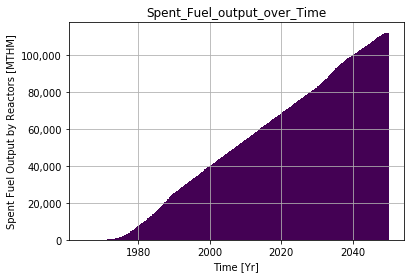

In [4]:
def spent_fuel_produced(cur): 
    """ Find timeseries of mass of spent fuel output by reactors 
    
    Parameters 
    ----------
    cur: sqlite cursor 
    
    Returns 
    -------
    timeseries list of spent fuel output by reactors
    """

    init_yr, init_month, duration, timestep = get_timesteps(cursor)
    spent_fuel = cur.execute('SELECT time, sum(quantity) FROM transactions '
                             'INNER JOIN resources '
                             'ON transactions.resourceid = resources.resourceid '
                             'WHERE Commodity = "spent_uox" '
                             'GROUP BY time ').fetchall()
    return an.get_timeseries_cum(spent_fuel,duration,True)


img_out = 'figures/'
pathlib.Path(img_out).mkdir(parents=True, exist_ok=True)
name = 'Spent_Fuel_output_over_Time'
output_reactor = {'Spent_Fuel_Output': spent_fuel_produced(cursor)}
an.stacked_bar_chart(output_reactor, timestep,
                     'Time [Yr]', 'Spent Fuel Output by Reactors [MTHM]',
                     name, img_out + name, ini_yr)
    
Image(filename=img_out + name + '.png')

** Hydrogen (nucid: 10030000) Isotopic Cumulative Mass Breakdown for Spent Fuel Output over time** 

/Users/gwenchee/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1717: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


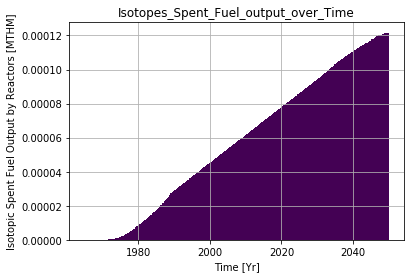

In [8]:
def isotope_list(cur):
    """ Find list of isotopes present in spent fuel output by reactor 
    
    Parameters 
    ----------
    cur: sqlite cursor 
    
    Returns 
    -------
    list of isotopes in spent fuel output by reactors
    """    
    
    init_yr, init_month, duration, timestep = get_timesteps(cursor)
    isotopes = cur.execute('SELECT time, sum(quantity)*massfrac FROM transactions '
                           'INNER JOIN resources '
                           'ON transactions.resourceid = resources.resourceid '
                           'LEFT OUTER JOIN compositions '
                           'ON resources.qualid = compositions.qualid '
                           'WHERE Commodity = "spent_uox" AND nucid = 10030000 '
                           ' GROUP BY time ').fetchall()
    return an.get_timeseries_cum(isotopes,duration,True)

img_out = 'figures/'
pathlib.Path(img_out).mkdir(parents=True, exist_ok=True)
name = 'Isotopes_Spent_Fuel_output_over_Time'
isotope_output_reactor = {'Isotopes_Spent_Fuel_Output': isotope_list(cursor)}
an.stacked_bar_chart(isotope_output_reactor, timestep,
                     'Time [Yr]', 'Isotopic Spent Fuel Output by Reactors [MTHM]',
                     name, img_out + name, ini_yr)
    
Image(filename=img_out + name + '.png')

** Hydrogen (nucid: 10030000) Isotopic Non-Cumulative Mass Breakdown for Spent Fuel Output over time** 

/Users/gwenchee/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1717: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


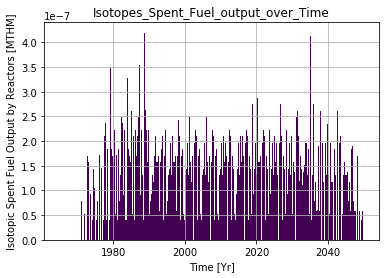

In [9]:
def isotope_list(cur):
    """ Find list of isotopes present in spent fuel output by reactor 
    
    Parameters 
    ----------
    cur: sqlite cursor 
    
    Returns 
    -------
    list of isotopes in spent fuel output by reactors
    """    
    
    init_yr, init_month, duration, timestep = get_timesteps(cursor)
    isotopes = cur.execute('SELECT time, sum(quantity)*massfrac FROM transactions '
                           'INNER JOIN resources '
                           'ON transactions.resourceid = resources.resourceid '
                           'LEFT OUTER JOIN compositions '
                           'ON resources.qualid = compositions.qualid '
                           'WHERE Commodity = "spent_uox" AND nucid = 10030000 '
                           ' GROUP BY time ').fetchall()
    return an.get_timeseries(isotopes,duration,True)

img_out = 'figures/'
pathlib.Path(img_out).mkdir(parents=True, exist_ok=True)
name = 'Isotopes_Spent_Fuel_output_over_Time'
isotope_output_reactor = {'Isotopes_Spent_Fuel_Output': isotope_list(cursor)}
an.stacked_bar_chart(isotope_output_reactor, timestep,
                     'Time [Yr]', 'Isotopic Spent Fuel Output by Reactors [MTHM]',
                     name, img_out + name, ini_yr)
    
Image(filename=img_out + name + '.png')

** Function to plot multiple isotopes on one plot (doesnt work)**

In [5]:
def isotope_list(cur):
    """ Find list of isotopes present in spent fuel output by reactor 
    
    Parameters 
    ----------
    cur: sqlite cursor 
    
    Returns 
    -------
    list of isotopes in spent fuel output by reactors
    """    
    
        isotopes = cur.execute('SELECT time, sum(quantity)*massfrac FROM transactions '
                               'INNER JOIN resources '
                               'ON transactions.resourceid = resources.resourceid '
                               'LEFT OUTER JOIN compositions '
                               'ON resources.qualid = compositions.qualid '
                               'WHERE Commodity = "spent_uox" '
                               ' GROUP BY time ').fetchall()
    
    isotope_list =[]
    mass_list = []
    time_list=[]
    
    for row in isotopes: 
        nucid = row['NucId']
        isotope_list.append(nucid) 
        mass = row['sum(quantity)*massfrac']
        mass_list.append(mass)
        time = row['Time']
        time_list.append(time)
    
            
    return isotope_list, mass_list, time_list  

isotopelist, masslist, timelist = isotope_list(cursor)
init_yr, init_month, duration, timestep = get_timesteps(cursor)
waste_dict = an.get_waste_dict(isotopelist, masslist, timelist, duration)
an.stacked_bar_chart(waste_dict, timestep,
                         'Time [Yr]', 'Spent Fuel Output by Reactors [MTHM]',
                         name, img_out + name, init_yr)


/Users/gwenchee/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1717: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)
